In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [2]:
from functools import partial
import jax # jax==0.1.67 / jaxlib==0.1.55
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle

rng = jax.random.PRNGKey(42)

* 다음 명령어로 설치  
pip install --upgrade jax==0.1.77 jaxlib==0.1.64+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

# Data

/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chairs/03001627/116bcb3b43de74b9df9054bbcf5c6adc
(50, 128, 128, 3)


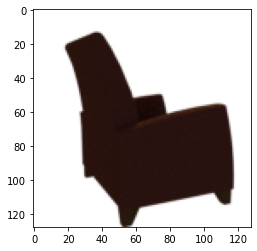

In [3]:
SPLITS_FILE = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chair_splits.json' # Update
DATA_PATH = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chairs/03001627' # Update

import json
import imageio

def load_train_ex(train_ex_dir, key=None):
    
    with open(os.path.join('/', train_ex_dir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(train_ex_dir, os.path.basename(frame['file_path']) + '.png')
        imgs.append(imageio.imread(fname))
        poses.append(np.array(frame['transform_matrix']))
    H, W = imgs[0].shape[:2]
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

with open(SPLITS_FILE, "r") as read_file:
    splits = json.load(read_file)

train_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['train'])]
test_exs =[os.path.join(DATA_PATH, d) for d in sorted(splits['test'])]
val_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['val'])]
for i in range(1):
    val_ex = val_exs[i]
    print(val_ex)
    images, poses, hwf = load_train_ex(val_ex, rng)
    print(images.shape)
    plt.imshow(images[0])
    plt.show()

# NeRF Model and Rendering

In [4]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [5]:
def render_rays(rnd_input, model, params, rays, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    near = 2
    far = 6

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = np.reshape(pts, [-1,3])
        
    raw = model.apply(params, pts_flat)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e-3], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2)
    acc_map = np.sum(weights, -1)    
    rgb_map = rgb_map + (1.-acc_map[...,None]) # white background 
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, rays, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, rays, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 4, 5, 6))

def render_fn(rnd_input, model, params, rays, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, rays[:,i:i+chunk], rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [6]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = False
                
    def __call__(self, coords, view_dirs=None):
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs = None
            viewdirs = np.repeat(viewdirs[...,None,:], coords.shape[-2], axis=-2)
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

# Meta Train

In [8]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

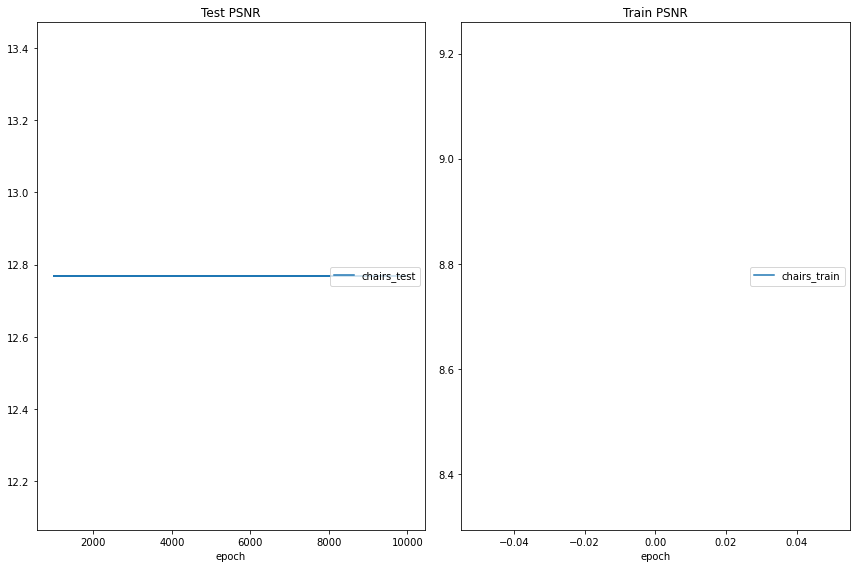

Test PSNR
	chairs_test      	 (min:   12.768, max:   12.768, cur:   12.768)
Train PSNR
	chairs_train     	 (min:    8.777, max:      inf, cur:      inf)


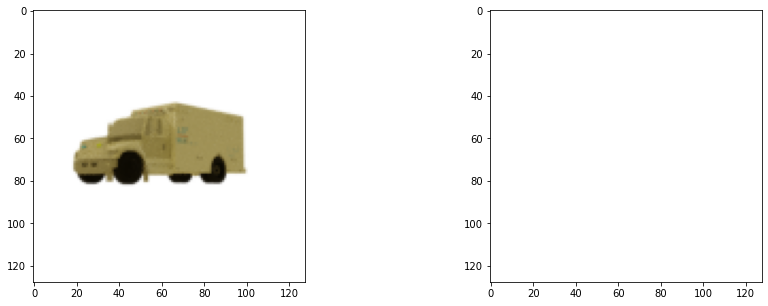

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/checkpoints_shapenet//chairs_10000.pkl'

In [11]:
exp_name = 'chairs'
max_iters = 10001
batch_size = 128

num_views = 25
test_time_views = 1

inner_update_steps = 32
inner_step_size = .5
lr = 5e-4

checkpoint_dir = 'checkpoints/checkpoints_shapenet/'

N_samples = 128

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))
params = model.init(rng, np.ones((1,3)))

test_inner_steps = 128*128 * 4 // batch_size

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

# train meta model inner_steps number of times to evaluate meta parameters
def update_network_weights_test(rng, images, rays, params, inner_steps):
    lowest_loss = 1e7
    for _ in range(inner_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
        if loss < lowest_loss:
            lowest_loss = loss
    return rng, params, lowest_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

for step in range(max_iters):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng, shape=(1,), minval=0, maxval=train_size)
        images, poses, hwf = load_train_ex(train_exs[img_idx[0]], rng)

        images = images[:num_views]
        poses = poses[:num_views]
    except:
        continue
    images = np.reshape(images, (-1,3))

    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step % 1000 == 0 and step != 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(5):
            images, poses, hwf = load_train_ex(val_exs[0], rng)
            test_holdout_images, test_images = np.split(images, [25], axis=0)
            test_holdout_poses, test_poses = np.split(poses, [25], axis=0)

            test_rays = get_ray_batch(hwf[0], hwf[1], hwf[2], test_poses)
            
            test_images = test_images[:test_time_views]
            test_rays = test_rays[:test_time_views]

            test_images = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))
            rng, test_params, test_inner_loss = update_network_weights_test(rng, test_images, test_rays, params, test_inner_steps)

            test_holdout_rays = get_rays(hwf[0], hwf[1], hwf[2], test_holdout_poses[0])
            test_result = np.clip(render_fn(rng, model, test_params, test_holdout_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images[0], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_holdout_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

# Test-time optimization

In [7]:
def train_single_model(max_iters, rng, num_views=25, lr=1e-4, batch_size=64, N_samples=128, init_params=None, image_idx=0):

    model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

    if init_params !=None:
        params = init_params
    else:
        params = model.init(rng, np.ones((1,3)))

    opt = optix.sgd(lr)
    opt_state = opt.init(params)

    mse_fn = jit(lambda x, y: np.mean((x - y)**2))
    psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

    @jit
    def update_model(rng, params, opt_state, image, rays):
        rng, rng_inputs = jax.random.split(rng)
        def loss_model(params):
            g = render_rays(rng_inputs, model, params, rays, N_samples, rand=True, )
            return mse_fn(g, image)
        model_loss, model_grad = jax.value_and_grad(loss_model, argnums=0)(params)
        updates, opt_state = opt.update(model_grad, opt_state)
        params = optix.apply_updates(params, updates)
        return rng, params, opt_state, model_loss

    images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)

    images = images[:num_views]
    poses = poses[:num_views]
    
    H, W, focal = hwf
    rays = get_ray_batch(H, W, focal, poses)

    images_ = images
    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    for step in range(max_iters):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=(images.shape[0]))
        train_image = images[idx,:]
        train_rays = rays[:,idx,:]

        rng, params, opt_state, loss = update_model(rng, params, opt_state, train_image, train_rays)

    return params, images_


### Load Checkpoint (optional)

In [8]:
checkpoint_file = '/mnt/disk2/JYChung/dataset/metaNeRF/checkpoints/shapenet/chair_meta_params_25_view_train.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

### Run TTO and render results

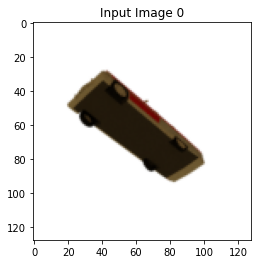

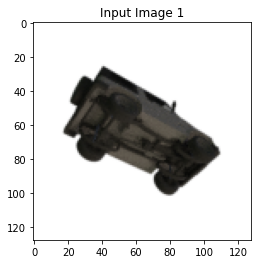

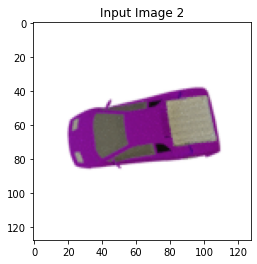

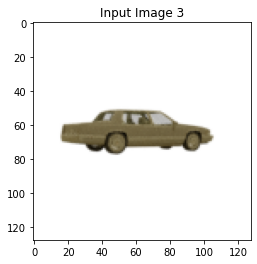

In [9]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(4):
    images, poses, hwf = load_train_ex(test_exs[i], rng)
    
    plt.imshow(images[0])
    plt.title('Input Image '+str(i))
    plt.show()

In [28]:
images, poses, hwf = load_train_ex(test_exs[0], rng)
poses.shape

(50, 4, 4)

# Dataset Analysis

## chair data

In [ ]:
for i in range(1):
    val_ex = val_exs[i]
    print(val_ex)
    images, poses, hwf = load_train_ex(val_ex, rng)
    print(images.shape)
    plt.imshow(images[0])
    plt.show()

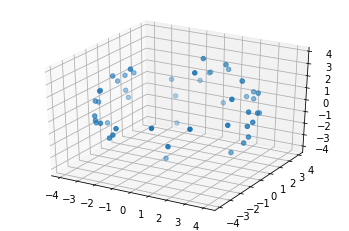

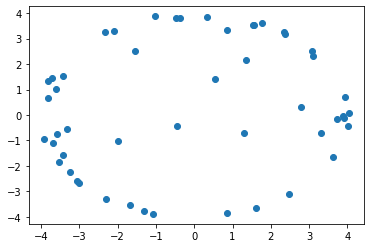

In [12]:
images, poses, hwf = load_train_ex(val_exs[0], rng)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(poses[:,0,3], poses[:,1,3], poses[:,2,3])
fig = plt.figure()
plt.scatter(poses[:,0,3], poses[:,1,3])

In [16]:
hwf

[128, 128, DeviceArray(177.77777, dtype=float32)]

In [36]:
print(params.keys())
a = dict(params)
del a['model/linear']
a.keys()

KeysOnlyKeysView(['model/linear', 'model/linear_1', 'model/linear_2', 'model/linear_3', 'model/linear_4', 'model/linear_5'])


dict_keys(['model/linear_1', 'model/linear_2', 'model/linear_3', 'model/linear_4', 'model/linear_5'])

In [37]:
print(type(params))
hk.

haiku._src.data_structures.FlatMapping

In [12]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(5):
    test_params, sup_images = train_single_model(max_iters, rng, num_views=num_views, lr=lr, init_params=params, image_idx=i)
    
    images, poses, hwf = load_train_ex(test_exs[i], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if num_views == 1:
        plt.imshow(images[0])
        plt.title('Input Image')
        plt.show()
    
    plt.figure(figsize=(15,6))
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        plt.subplot(2,5,j+1)
        plt.imshow(test_images[j])
        plt.title('Target')
        plt.subplot(2,5,j+6)
        plt.imshow(test_result)
        plt.title('Reconstruction')
    plt.show()

KeyboardInterrupt: 

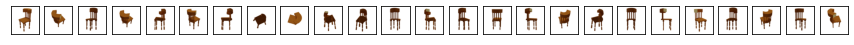

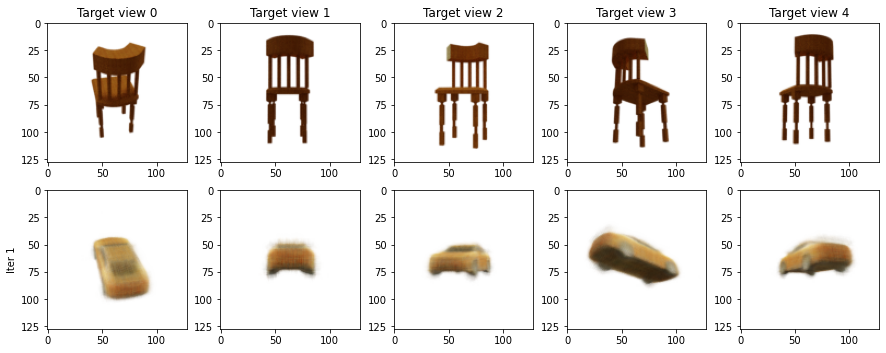

[DeviceArray(11.676176, dtype=float32), DeviceArray(11.202603, dtype=float32), DeviceArray(12.050274, dtype=float32), DeviceArray(10.518273, dtype=float32), DeviceArray(10.753048, dtype=float32), DeviceArray(11.240075, dtype=float32)]
Time:  [1.2280445098876953]


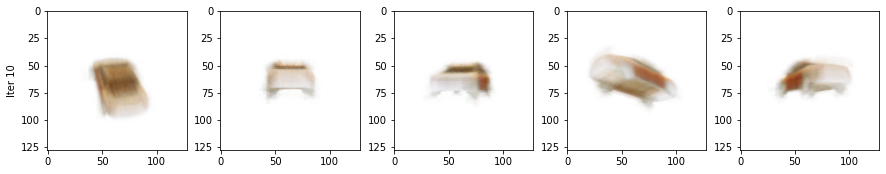

[DeviceArray(12.542299, dtype=float32), DeviceArray(11.073775, dtype=float32), DeviceArray(12.035772, dtype=float32), DeviceArray(11.414351, dtype=float32), DeviceArray(11.129173, dtype=float32), DeviceArray(11.639075, dtype=float32)]
Time:  [1.2280445098876953, 0.7751107215881348]


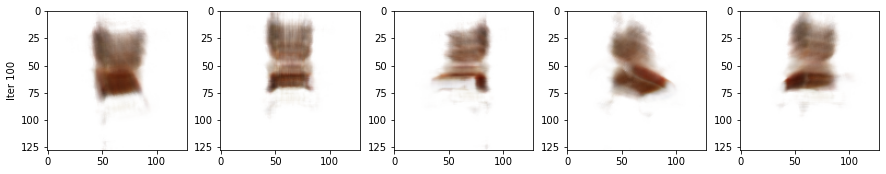

[DeviceArray(17.114065, dtype=float32), DeviceArray(13.818187, dtype=float32), DeviceArray(13.801287, dtype=float32), DeviceArray(14.260001, dtype=float32), DeviceArray(13.695328, dtype=float32), DeviceArray(14.537773, dtype=float32)]
Time:  [1.2280445098876953, 0.7751107215881348, 1.0202479362487793]


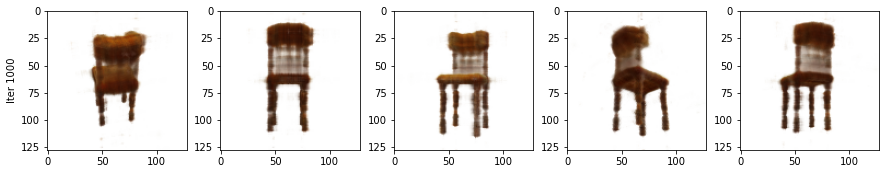

[DeviceArray(23.203117, dtype=float32), DeviceArray(19.130476, dtype=float32), DeviceArray(17.847555, dtype=float32), DeviceArray(22.486942, dtype=float32), DeviceArray(19.425886, dtype=float32), DeviceArray(20.418797, dtype=float32)]
Time:  [1.2280445098876953, 0.7751107215881348, 1.0202479362487793, 3.903822660446167]


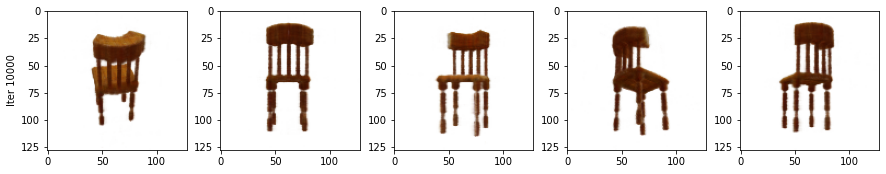

[DeviceArray(28.822018, dtype=float32), DeviceArray(28.449116, dtype=float32), DeviceArray(18.84539, dtype=float32), DeviceArray(25.858862, dtype=float32), DeviceArray(27.666681, dtype=float32), DeviceArray(25.928415, dtype=float32)]
Time:  [1.2280445098876953, 0.7751107215881348, 1.0202479362487793, 3.903822660446167, 32.639082193374634]


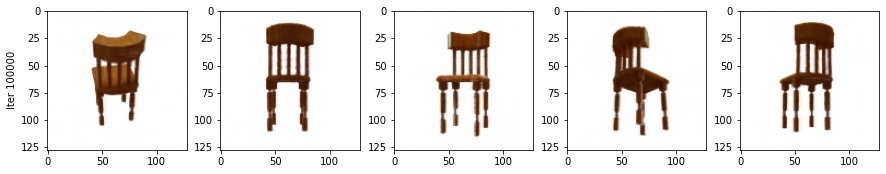

[DeviceArray(30.259262, dtype=float32), DeviceArray(29.032736, dtype=float32), DeviceArray(18.541397, dtype=float32), DeviceArray(26.598442, dtype=float32), DeviceArray(28.97047, dtype=float32), DeviceArray(26.680464, dtype=float32)]
Time:  [1.2280445098876953, 0.7751107215881348, 1.0202479362487793, 3.903822660446167, 32.639082193374634, 321.5482511520386]


In [13]:
def psnr(gt, pred):
    assert gt.shape == pred.shape
    mse = np.mean((gt-pred)**2)
    psnr = -10 * np.log10(mse)
    return psnr

from time import time
max_iters = [1, 10, 100, 1000, 10000, 100000]
num_views = 25 # How many views to test-time optimize over
image_idx = 0
lr= 0.5
timesave = []

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(len(max_iters)):
    prevtime = time()
    test_params, sup_images = train_single_model(max_iters[i], rng, num_views=num_views, lr=lr, init_params=params, image_idx=image_idx)
    timesave.append(time()-prevtime)
    
    images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if i==0:
        if num_views>=5:
            plt.figure(figsize=(15,3))
        else:
            plt.figure(figsize=(3*num_views,3))
        for k in range(num_views):
            plt.subplot(1,num_views,k+1)
            plt.imshow(images[k])
            if k==0:
                plt.ylabel('Input Image')
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        plt.show()
    
    plt.figure(figsize=(15,3*(1+len(max_iters))))
    test_psnr = []
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        if i==0:
            plt.subplot(1+len(max_iters),5,j+1)
            plt.imshow(test_images[j])
            plt.title('Target view '+str(j))
        plt.subplot(1+len(max_iters),5,j+(i+1)*5+1)
        plt.imshow(test_result)
        if j==0:
            plt.ylabel('Iter '+str(max_iters[i]))
        
        test_psnr.append(psnr(test_images[j], test_result))
    plt.show()
    test_psnr.append(np.mean(np.array(test_psnr)))
    print(test_psnr)
    print("Time: ", timesave)


DeviceArray(14.499118, dtype=float32)

In [32]:
print(timesave)

[1.0732474327087402, 0.7497632503509521, 1.0406427383422852, 3.9494285583496094, 32.511422634124756]


# Test on zju_mocap

* coreView_396

(1024, 1024, 3)


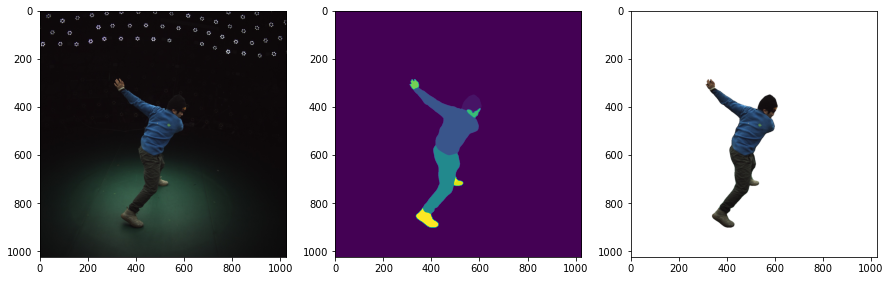

In [17]:
zjupath = "/mnt/disk2/JYChung/dataset/neuralbody/zju_mocap/CoreView_396"
maskpath = "mask_cihp/"
camerapath = "Camera_B" 

cameraidx = 1
sceneidx = 810
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,3,1)
img = imageio.imread(os.path.join(zjupath, camerapath+str(cameraidx), str(sceneidx).zfill(6)+".jpg")) 
print(img.shape)
plt.imshow(img)

fig.add_subplot(1,3,2)
maskseg = imageio.imread(os.path.join(zjupath, maskpath, camerapath+str(cameraidx), str(sceneidx).zfill(6)+".png"))
plt.imshow(maskseg/np.max(maskseg)*255)

fig.add_subplot(1,3,3)
mask = maskseg[...,None]>0
maskedimg = img*mask+255*(1-mask)
plt.imshow(maskedimg)


In [18]:
import cv2
import glob
import os
import json
import numpy

def get_cams(rootp):
    intri = cv2.FileStorage(os.path.join(rootp,'intri.yml'), cv2.FILE_STORAGE_READ)
    extri = cv2.FileStorage(os.path.join(rootp,'extri.yml'), cv2.FILE_STORAGE_READ)
    cams = {'K': [], 'D': [], 'R': [], 'T': []}
    for i in range(23):
        cams['K'].append(intri.getNode('K_Camera_B{}'.format(i + 1)).mat())
        cams['D'].append(intri.getNode('dist_Camera_B{}'.format(i + 1)).mat().T)
        cams['R'].append(extri.getNode('Rot_Camera_B{}'.format(i + 1)).mat())
        cams['T'].append(extri.getNode('T_Camera_B{}'.format(i + 1)).mat())
    # resize 1024 to 128 effects on the intrinsic
    
    return cams


def get_img_paths(rootp):
    all_ims = []
    for i in range(23):
        i = i + 1
        data_root = os.path.join(rootp, 'Camera_B{}'.format(i))
        ims = glob.glob(os.path.join(data_root, '*.jpg'))
        ims = np.array(sorted(ims))
        all_ims.append(ims)
    num_img = min([len(ims) for ims in all_ims])
    all_ims = [ims[:num_img] for ims in all_ims]
    all_ims = np.stack(all_ims, axis=1)
    return all_ims



dict_keys(['K', 'D', 'R', 'T'])
(23, 3, 3)
(23, 5, 1)
(23, 3, 3)
(23, 3, 1)
[[1.07428139e+03 0.00000000e+00 5.42834206e+02]
 [0.00000000e+00 1.07542291e+03 4.84883561e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
k  [[1074.2814     0.       542.8342 ]
 [   0.      1075.423    484.88358]]
t:  [[[ 0.05873722]
  [ 0.99344826]
  [ 2.98926   ]]

 [[ 0.38256624]
  [ 0.8987751 ]
  [ 2.9481668 ]]

 [[ 0.34011585]
  [ 0.9420295 ]
  [ 2.925268  ]]

 [[-0.13295   ]
  [ 0.7244874 ]
  [ 2.831746  ]]

 [[-0.18207544]
  [ 0.95599955]
  [ 2.842892  ]]

 [[-0.60855967]
  [ 0.9118696 ]
  [ 2.9081423 ]]

 [[-0.73084444]
  [ 1.0100074 ]
  [ 2.856098  ]]

 [[-0.30312124]
  [ 0.92551017]
  [ 3.128174  ]]

 [[-0.29604116]
  [ 0.8777488 ]
  [ 3.2213795 ]]

 [[-0.83634543]
  [ 0.8765823 ]
  [ 3.2414048 ]]

 [[-0.27986327]
  [ 0.6593421 ]
  [ 3.4694335 ]]

 [[-0.7843239 ]
  [ 0.62082154]
  [ 3.5802846 ]]

 [[-0.7327523 ]
  [ 0.78537947]
  [ 3.553032  ]]

 [[-0.3780256 ]
  [ 0.8363512 ]
  [ 3.6112878 ]]


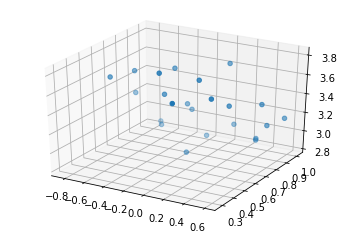

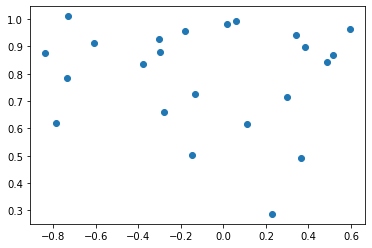

In [19]:
cams = get_cams(zjupath)

print(cams.keys())
print(np.array(cams['K']).shape)
print(np.array(cams['D']).shape)
print(np.array(cams['R']).shape)
print(np.array(cams['T']).shape)
print(cams['K'][0])

fig = plt.figure()
ax = fig.gca(projection='3d')
k = np.array(cams['K'][0])
print("k ", k[:2])
t = np.array(cams['T'])
t2 = -np.array(cams['R']).transpose((0,2,1))*np.array(cams['T'])
print("t: ", t)
kk = np.matmul(np.array(cams['K']), t)
ax.scatter(t[:,0,0], t[:,1,0], t[:,2,0])
fig = plt.figure()
plt.scatter(t[:,0,0], t[:,1,0])

In [41]:
images, poses, hwf = load_zju_mocap(sceneidx)

In [42]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [47]:
rays = get_ray_batch(hwf[0], hwf[1], hwf[2], poses)

def get_rays_nb(H, W, K, R, T):
    # calculate the camera origin
    rays_o = -np.dot(R.T, T).ravel()
    # calculate the world coodinates of pixels
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32),
                       indexing='xy')
    xy1 = np.stack([i, j, np.ones_like(i)], axis=2)
    pixel_camera = np.dot(xy1, np.linalg.inv(K).T)
    pixel_world = np.dot(pixel_camera - T.ravel(), R)
    # calculate the ray direction
    rays_d = pixel_world - rays_o[None, None]
    rays_o = np.broadcast_to(rays_o, rays_d.shape)
    return rays_o, rays_d

bb = get_rays(hwf[0], hwf[1], hwf[2], poses[0])
K = cams['K'][0]
K[:2] /= 8
cc = get_rays_nb(hwf[0], hwf[1], K, cams['R'][0], cams['T'][0])
print(bb[1][:5,:5,0], cc[1][:5,:5,0])

[[0.3602151  0.35281914 0.3454232  0.33802727 0.33063132]
 [0.36085296 0.353457   0.34606105 0.33866513 0.33126917]
 [0.3614908  0.35409486 0.34669888 0.33930296 0.33190703]
 [0.36212865 0.3547327  0.34733674 0.33994082 0.33254486]
 [0.3627665  0.35537055 0.3479746  0.34057868 0.33318272]] [[0.6130566  0.60565674 0.5982569  0.59085697 0.5834571 ]
 [0.61241907 0.6050192  0.59761935 0.59021944 0.5828196 ]
 [0.61178154 0.6043817  0.5969818  0.5895819  0.58218205]
 [0.61114407 0.6037442  0.59634435 0.58894444 0.5815446 ]
 [0.61050653 0.6031067  0.5957068  0.5883069  0.58090705]]
/home/chung/anaconda3/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , tr

In [29]:
a = -np.dot(cams['R'][0], cams['T'][0]).ravel()
b = np.array(Tm)[:3,-1]

In [49]:
print(K, hwf[2])
print(np.linalg.inv(K).T)

[[134.28517355   0.          67.85427572]
 [  0.         134.42786433  60.61044514]
 [  0.           0.           1.        ]] 134.35652
[[ 0.00744684  0.          0.        ]
 [ 0.          0.00743893  0.        ]
 [-0.50529987 -0.45087707  1.        ]]
/home/chung/anaconda3/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [19]:
print(bb[0][:5,:5,0], cc[0][:5,:5,0])

[[-2.805754 -2.805754 -2.805754 -2.805754 -2.805754]
 [-2.805754 -2.805754 -2.805754 -2.805754 -2.805754]
 [-2.805754 -2.805754 -2.805754 -2.805754 -2.805754]
 [-2.805754 -2.805754 -2.805754 -2.805754 -2.805754]
 [-2.805754 -2.805754 -2.805754 -2.805754 -2.805754]] [[0.05873718 0.05873718 0.05873718 0.05873718 0.05873718]
 [0.05873718 0.05873718 0.05873718 0.05873718 0.05873718]
 [0.05873718 0.05873718 0.05873718 0.05873718 0.05873718]
 [0.05873718 0.05873718 0.05873718 0.05873718 0.05873718]
 [0.05873718 0.05873718 0.05873718 0.05873718 0.05873718]]


In [87]:
images.shape

(23, 128, 128, 3)

In [97]:
aa = cv2.undistort(oriimg, cams['K'][0], cams['D'][0])

In [93]:
oriimg = imageio.imread(os.path.join(zjupath, "Camera_B"+str(1), str(sceneidx).zfill(6)+".jpg")) 

In [105]:
aa = cv2.undistort((images[0]*255).astype(np.uint8), cams['K'][0], cams['D'][0])

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [109]:
mask = imageio.imread(os.path.join(zjupath, "mask_cihp/Camera_B"+str(1), str(sceneidx).zfill(6)+".png"))[...,None]>0 

In [114]:
type(mask)

imageio.core.util.Array

In [120]:
aa = cv2.undistort(mask.astype(numpy.uint8), cams['K'][0], cams['D'][0])

In [107]:
print(np.max(oriimg))
print(np.max(images[0]))
print(type(oriimg))
print(type(images))

255
1.0
<class 'imageio.core.util.Array'>
<class 'jax.interpreters.xla.DeviceArray'>


In [40]:
zjupath = "/mnt/disk2/JYChung/dataset/neuralbody/zju_mocap/CoreView_396"
maskpath = "mask_cihp/"
camerapath = "Camera_B" 

import json
import imageio
from skimage.transform import resize

def load_zju_mocap(sceneidx=810, ratio=8):
    imgs = []
    poses = []

    cams = get_cams(zjupath)
    # img_paths = get_img_paths(zjupath)

    for camidx in range(23):
        # masked, resized img
        oriimg = imageio.imread(os.path.join(zjupath, "Camera_B"+str(camidx+1), str(sceneidx).zfill(6)+".jpg")) 
        mask = imageio.imread(os.path.join(zjupath, "mask_cihp/Camera_B"+str(camidx+1), str(sceneidx).zfill(6)+".png"))[...,None]>0  
        oriimg = cv2.undistort(oriimg, cams['K'][camidx], cams['D'][camidx])
        mask = cv2.undistort(mask.astype(numpy.uint8), cams['K'][0], cams['D'][0])[...,None]
        maskedimg = (oriimg*mask+255*(1-mask))/255.
        resizedimg = resize(maskedimg, (maskedimg.shape[0]/ratio, maskedimg.shape[1]/ratio))
        imgs.append(np.array(resizedimg))

        cams['K'][camidx][:2] /= ratio
        # Transformation matrix
        Tmat = numpy.zeros((4,4))
        Tmat[0:3,0:3] = cams['R'][camidx].T
        Tmat[0:3,3] = -np.dot(cams['R'][camidx].T, cams['T'][camidx])[:,0]
        Tmat[3,3] = 1.0
        poses.append(np.array(Tmat))

    # print(np.max(oriimg))
    # print(np.max(mask))
    # print(np.max(maskedimg))
    # print(np.max(resizedimg))
    # print(np.max(imgs[0]))

    imgs = np.array(imgs)
    poses = np.array(poses)
    H = imgs[0].shape[0]
    W = imgs[0].shape[1]
    focal = np.mean(np.diag(cams['K'][0])[0:2])    

    assert(imgs.shape[0]==23 and poses.shape[0]==23)
    # assert(H==128 and W==128)

    return imgs, poses, [H,W,focal]


In [85]:
print(test_exs[0])
a, b, c= load_zju_mocap()
print(a.shape, b.shape, c)
print(b[0])

plt.imshow(a[0])

/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/cars/02958343/11b09de6631b3b3ad997cda1a938a10d


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [74]:
b[0]

DeviceArray([[-8.2260664e+03,  4.9537295e+03,  7.1579523e+02,
               1.3486183e+04],
             [-4.5683157e+02,  1.2927626e+03,  9.3373145e+03,
               2.0142561e+04],
             [ 7.2303407e-02,  9.5528370e-01,  2.8671455e-01,
               2.9892600e+00],
             [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
               1.0000000e+00]], dtype=float32)

In [14]:
def train_zju_model(max_iters, rng, viewlist, num_views=23, lr=1e-4, batch_size=64, N_samples=128, init_params=None, sceneidx=810):

    model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

    if init_params !=None:
        params = init_params
    else:
        params = model.init(rng, np.ones((1,3)))

    opt = optix.sgd(lr)
    opt_state = opt.init(params)

    mse_fn = jit(lambda x, y: np.mean((x - y)**2))
    psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

    @jit
    def update_model(rng, params, opt_state, image, rays):
        rng, rng_inputs = jax.random.split(rng)
        def loss_model(params):
            g = render_rays(rng_inputs, model, params, rays, N_samples, rand=True, )
            return mse_fn(g, image)
        model_loss, model_grad = jax.value_and_grad(loss_model, argnums=0)(params)
        updates, opt_state = opt.update(model_grad, opt_state)
        params = optix.apply_updates(params, updates)
        return rng, params, opt_state, model_loss

    # images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    # images, test_images = np.split(images, [25], axis=0)
    # poses, test_poses = np.split(poses, [25], axis=0)
    images, poses, hwf = load_zju_mocap(sceneidx)
    images = images[viewlist[:num_views]]
    poses = poses[viewlist[:num_views]]
    
    H, W, focal = hwf
    rays = get_ray_batch(H, W, focal, poses)

    images_ = images
    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    for step in range(max_iters):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=(images.shape[0]))
        train_image = images[idx,:]
        train_rays = rays[:,idx,:]

        rng, params, opt_state, loss = update_model(rng, params, opt_state, train_image, train_rays)

    return params, images_


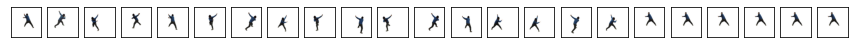

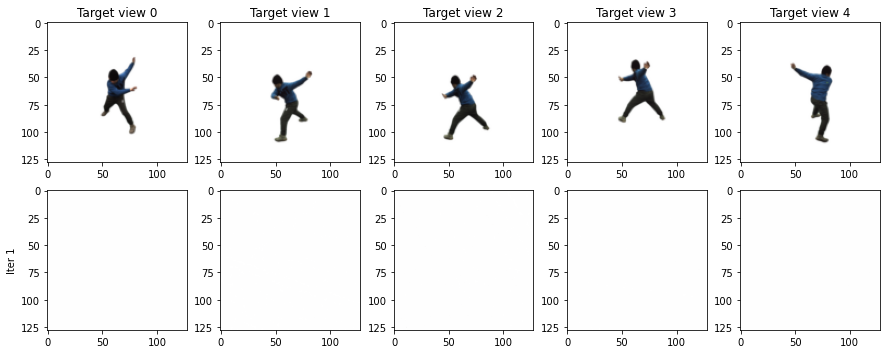

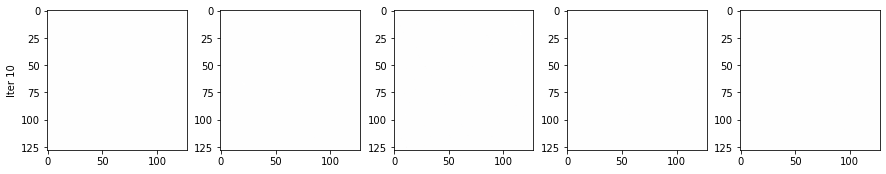

KeyboardInterrupt: 

In [76]:
from time import time
max_iters = [1, 10, 100, 1000, 10000]
num_views = 23 # How many views to test-time optimize over
test_views = 5
sceneidx = 810
lr= 0.5
timesave = []

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

viewlist = numpy.random.choice(numpy.arange(23), size=(23-test_views), replace=False)
testlist = numpy.setdiff1d(numpy.arange(23), viewlist)

for i in range(len(max_iters)):
    prevtime = time()
    test_params, sup_images = train_zju_model(max_iters[i], rng, np.array(viewlist), num_views=num_views, lr=lr, init_params=params, sceneidx=sceneidx)
    timesave.append(time()-prevtime)
    
    images, poses, hwf = load_zju_mocap(sceneidx)
    test_images = images[testlist]
    images = images[viewlist[:num_views]]
    test_poses = poses[testlist]
    poses = poses[viewlist[:num_views]]
    # poses, test_poses = np.split(poses, [25], axis=0)
    
    if i==0:
        if num_views>=5:
            plt.figure(figsize=(15,3))
        else:
            plt.figure(figsize=(3*num_views,3))
        for k in range(num_views):
            plt.subplot(1,num_views,k+1)
            plt.imshow(images[k])
            if k==0:
                plt.ylabel('Input Image')
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        plt.show()
    
    plt.figure(figsize=(15,3*(1+len(max_iters))))
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        if i==0:
            plt.subplot(1+len(max_iters),5,j+1)
            plt.imshow(test_images[j])
            plt.title('Target view '+str(j))
        plt.subplot(1+len(max_iters),5,j+(i+1)*len(max_iters)+1)
        plt.imshow(test_result)
        if j==0:
            plt.ylabel('Iter '+str(max_iters[i]))
    plt.show()



In [41]:
np.min(test_images[0])

DeviceArray(8.1315163e-19, dtype=float32)

DeviceArray(1., dtype=float32)

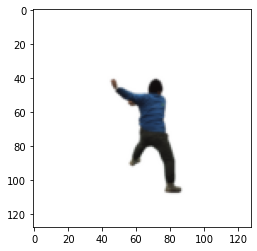

In [87]:
plt.imshow(images[0])
np.max(images[0])